# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

In [1]:
import pandas as pd
dataset = pd.read_csv('sakura.csv',header=0)
bloomdata = dataset.loc[dataset['bloom'] == 1]
bloomdata = bloomdata.drop(["serial","local pressure","sea pressure","total preci","hr1 preci","min10 preci","avg temp","max temp","min temp","avg humid","min humid","sun hours"], axis=1)
bloomdata

,year,month,day,bloom
90,1961,4,1,1
455,1962,4,1,1
820,1963,4,1,1
1187,1964,4,2,1
1552,1965,4,2,1
1904,1966,3,20,1
2279,1967,3,30,1
2644,1968,3,29,1
3017,1969,4,6,1
3383,1970,4,7,1


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [2]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import calendar
import warnings

def ignore_warning(*args, **kwargs):
    pass

warnings.warn = ignore_warning #ignoring warning

## Creating Test Data

In [3]:
testdataset= pd.read_csv("sakura.csv", header = 0)
yearlist = np.unique(testdataset[['year']]).tolist()
yearlist = [e for e in yearlist if e not in (1966, 1971, 1985, 1994, 2008)]
for year in yearlist:
    testdataset = testdataset[testdataset["year"] != year]
testdataset.to_csv("testdataset.csv", index=False)

In [4]:
testdataset.describe()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,8879.340635,1984.812705,6.523549,15.727820,1009.567032,1013.838664,4.155257,1.483297,0.558817,15.940635,19.723658,12.513308,63.065717,45.940307,5.307558,0.002738
std,5584.169077,15.285770,3.449478,8.801735,6.569081,6.650563,12.756076,4.069556,1.678467,7.938540,8.011453,8.246528,15.401194,16.638271,3.924720,0.052271
min,1826.000000,1966.000000,1.000000,1.000000,983.000000,987.200000,0.000000,0.000000,0.000000,0.900000,3.100000,-3.200000,23.000000,9.000000,0.000000,0.000000
25%,3743.250000,1971.000000,4.000000,8.000000,1005.200000,1009.400000,0.000000,0.000000,0.000000,8.700000,12.725000,4.800000,51.000000,32.000000,1.300000,0.000000
50%,8948.500000,1985.000000,7.000000,16.000000,1009.300000,1013.500000,0.000000,0.000000,0.000000,16.050000,19.700000,12.500000,65.000000,46.000000,5.700000,0.000000
75%,12326.750000,1994.000000,10.000000,23.000000,1014.000000,1018.375000,1.500000,1.000000,0.500000,22.200000,25.900000,19.400000,74.000000,58.000000,8.700000,0.000000
max,17531.000000,2008.000000,12.000000,31.000000,1032.500000,1037.000000,225.500000,59.500000,35.000000,32.400000,39.100000,29.300000,100.000000,100.000000,13.100000,1.000000


*From above dataframe, we can see that data is pretty well balanced because all the features has equal number of value count*

## Creating Train Data

In [5]:
traindataset = pd.read_csv("sakura.csv", header = 0)
traindataset = traindataset[traindataset.year != 1966]
traindataset = traindataset[traindataset.year != 1971]
traindataset = traindataset[traindataset.year != 1985]
traindataset = traindataset[traindataset.year != 1994]
traindataset = traindataset[traindataset.year != 2008]
traindataset.to_csv("traindataset.csv", index=False)

In [6]:
traindataset.describe()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
count,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000,18718.000000
mean,10407.309542,1988.997863,6.501122,15.728871,1009.886719,1013.812047,4.075927,1.506235,0.574362,16.042034,19.933524,12.580815,62.671867,45.099102,5.340987,0.002778
std,5946.128943,16.280187,3.455187,8.799989,6.833963,6.825935,12.415566,4.332523,1.642980,7.888928,7.969077,8.201870,15.587476,16.952125,3.996526,0.052636
min,0.000000,1961.000000,1.000000,1.000000,975.900000,980.100000,0.000000,0.000000,0.000000,-1.200000,-0.200000,-5.500000,19.000000,6.000000,0.000000,0.000000
25%,5409.250000,1975.000000,3.000000,8.000000,1005.200000,1009.100000,0.000000,0.000000,0.000000,8.700000,12.900000,5.000000,51.000000,31.000000,1.000000,0.000000
50%,10453.500000,1989.000000,7.000000,16.000000,1009.800000,1013.700000,0.000000,0.000000,0.000000,16.400000,20.200000,12.800000,64.000000,45.000000,5.900000,0.000000
75%,15497.750000,2003.000000,10.000000,23.000000,1014.600000,1018.600000,1.500000,1.000000,0.500000,22.500000,26.300000,19.600000,74.000000,57.000000,8.800000,0.000000
max,20543.000000,2017.000000,12.000000,31.000000,1033.100000,1035.900000,259.500000,82.500000,34.000000,33.200000,39.500000,30.400000,100.000000,100.000000,13.800000,1.000000


*From above dataframe, we can see that data is pretty well balanced because all the features has equal number of value count*

In [7]:
traindataset.corr()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
serial,1.000000,0.999842,0.006890,0.001463,-0.056436,-0.003596,0.023937,0.036786,0.038467,0.056798,0.040754,0.071142,-0.071005,-0.061099,-0.010979,0.000462
year,0.999842,1.000000,-0.010812,-0.000201,-0.057467,-0.004536,0.023169,0.035816,0.037372,0.050652,0.035034,0.064819,-0.074855,-0.065353,-0.009307,0.001316
month,0.006890,-0.010812,1.000000,0.010566,0.056541,0.051237,0.043192,0.054925,0.062327,0.349340,0.325352,0.359190,0.218917,0.241091,-0.093996,-0.050252
day,0.001463,-0.000201,0.010566,1.000000,0.008351,0.008270,0.005555,0.002667,-0.001309,0.005262,0.004051,0.005423,0.003644,0.008232,-0.005976,0.028271
local pressure,-0.056436,-0.057467,0.056541,0.008351,1.000000,0.989409,-0.196842,-0.226128,-0.225808,-0.375577,-0.381032,-0.372947,-0.254237,-0.185800,0.082935,0.010054
sea pressure,-0.003596,-0.004536,0.051237,0.008270,0.989409,1.000000,-0.197416,-0.226506,-0.225293,-0.390334,-0.400082,-0.385130,-0.277271,-0.200926,0.081470,0.010554
total preci,0.023937,0.023169,0.043192,0.005555,-0.196842,-0.197416,1.000000,0.825964,0.714088,0.052195,0.019068,0.091073,0.400649,0.377799,-0.341399,-0.011074
hr1 preci,0.036786,0.035816,0.054925,0.002667,-0.226128,-0.226506,0.825964,1.000000,0.925821,0.122603,0.100784,0.147054,0.361350,0.327030,-0.296299,-0.010502
min10 preci,0.038467,0.037372,0.062327,-0.001309,-0.225808,-0.225293,0.714088,0.925821,1.000000,0.157071,0.137433,0.178569,0.350908,0.317758,-0.278784,-0.012212
avg temp,0.056798,0.050652,0.349340,0.005262,-0.375577,-0.390334,0.052195,0.122603,0.157071,1.000000,0.985420,0.984633,0.499452,0.455241,0.008458,-0.028511


In [8]:
testdataset.corr()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
serial,1.000000,0.999822,0.017728,0.003030,0.031686,0.033475,0.008445,0.033682,0.026014,0.072921,0.055703,0.095936,-0.065586,-0.072005,0.005745,-0.000949
year,0.999822,1.000000,-0.001091,0.001254,0.030256,0.032186,0.008323,0.033092,0.025244,0.066327,0.049431,0.089376,-0.069406,-0.076267,0.007000,-0.000044
month,0.017728,-0.001091,1.000000,0.010796,0.075594,0.067992,0.002533,0.030226,0.040597,0.354001,0.336823,0.352234,0.203962,0.226832,-0.065383,-0.050501
day,0.003030,0.001254,0.010796,1.000000,-0.001133,-0.000840,0.051896,0.022301,0.011458,-0.004105,-0.005237,-0.002514,0.002557,0.005124,-0.016399,0.032587
local pressure,0.031686,0.030256,0.075594,-0.001133,1.000000,0.999809,-0.199367,-0.221611,-0.186503,-0.390704,-0.404044,-0.386393,-0.278309,-0.193001,0.038553,0.011912
sea pressure,0.033475,0.032186,0.067992,-0.000840,0.999809,1.000000,-0.198784,-0.222357,-0.187816,-0.407063,-0.420070,-0.402458,-0.286429,-0.200811,0.037326,0.012148
total preci,0.008445,0.008323,0.002533,0.051896,-0.199367,-0.198784,1.000000,0.791476,0.644245,0.058746,0.024255,0.100008,0.406306,0.384425,-0.336521,-0.009678
hr1 preci,0.033682,0.033092,0.030226,0.022301,-0.221611,-0.222357,0.791476,1.000000,0.913147,0.139712,0.118753,0.166689,0.376763,0.339831,-0.297740,-0.012664
min10 preci,0.026014,0.025244,0.040597,0.011458,-0.186503,-0.187816,0.644245,0.913147,1.000000,0.157586,0.141522,0.178824,0.331294,0.300877,-0.245462,-0.014328
avg temp,0.072921,0.066327,0.354001,-0.004105,-0.390704,-0.407063,0.058746,0.139712,0.157586,1.000000,0.987314,0.985314,0.510388,0.460009,0.044229,-0.023245


*The above dataframe provides with the correlation between various features. It shows that how the different features correlate with one another.*

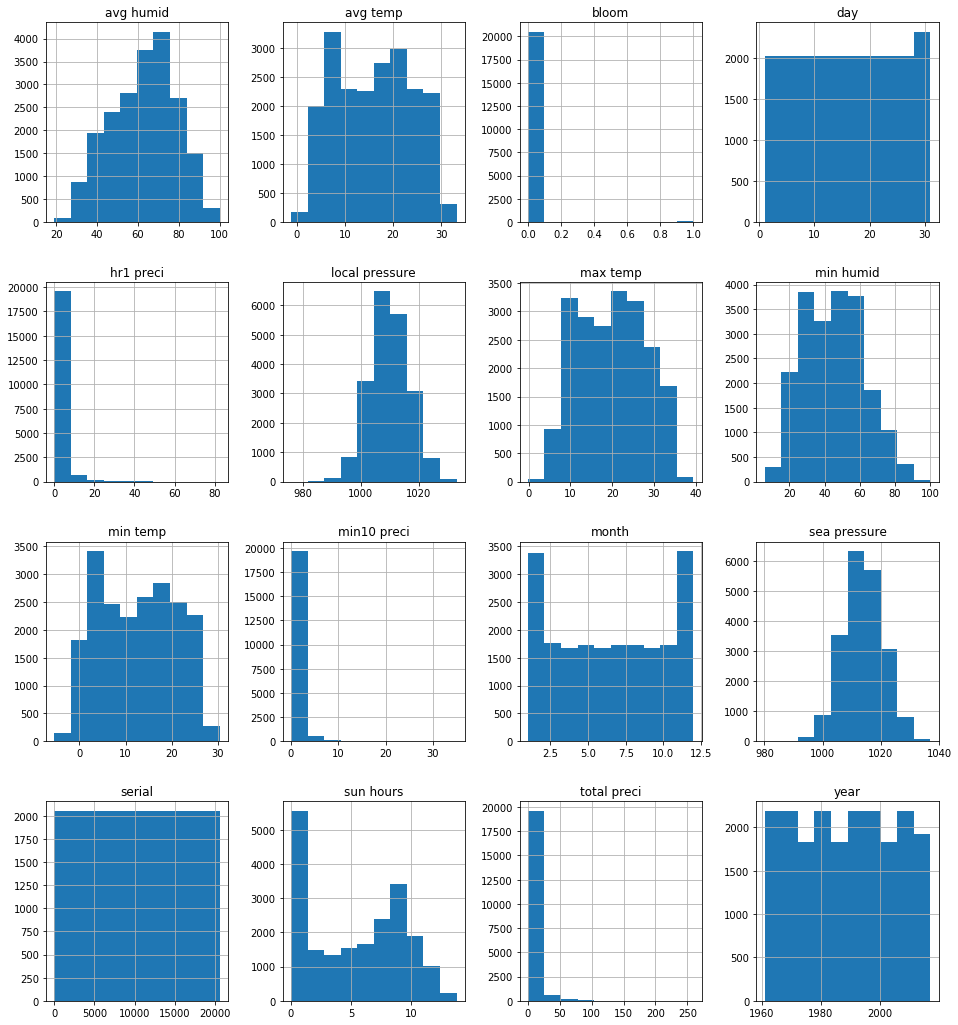

In [9]:
dataset = pd.read_csv("sakura.csv", header=0)
plt.rcParams["figure.figsize"] = [16,18]
dataset.hist()
plt.show()

True


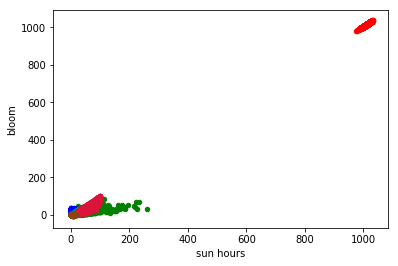

In [11]:
dataset = pd.read_csv("sakura.csv", header=0)
ax1 = dataset.plot(kind='scatter', x='local pressure', y='sea pressure', color='r')    
ax2 = dataset.plot(kind='scatter', x='total preci', y='hr1 preci', color='g', ax=ax1)    
ax3 = dataset.plot(kind='scatter', x='min10 preci', y='avg temp', color='b', ax=ax1)
ax4 = dataset.plot(kind='scatter', x='max temp', y='min temp', color='darkcyan', ax=ax1)
ax5 = dataset.plot(kind='scatter', x='avg humid', y='min humid', color='crimson', ax=ax1)
ax6 = dataset.plot(kind='scatter', x='sun hours', y='bloom', color='saddlebrown', ax=ax1)
print(ax1 == ax2 == ax3 == ax4 == ax5 == ax6)

## Calculating Tmean

In [12]:
columns = list(traindataset.columns.values) #getting the column data

#only keeping the necessary column name. As in this case, we only need year, month, day, max temp and bloom data
#as we are only calculating the Tmean using max temp value
columns = [e for e in columns if e not in ("year","month","day","max temp", "bloom")] 

#saving the features data in dataframe
sixHundredDataset = traindataset.drop(columns,axis=1)

#getting the data of till bloom date
sixHundredDataset = sixHundredDataset[sixHundredDataset["month"] != 1]

#getting all the years bloom data and making sum of that data
sixHundredDataset = sixHundredDataset[sixHundredDataset.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]

#getting the sum of max temp data for each year till blooming date
sixHundredDataset = sixHundredDataset.groupby(["year"])["max temp"].sum()

#calculating the Tmean
tMean = sixHundredDataset.values.sum()/52
print(tMean)

638.3557692307693


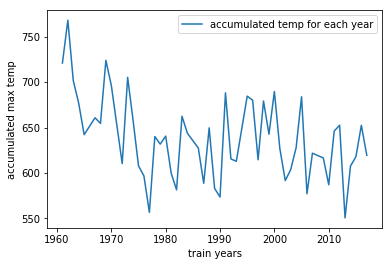

In [13]:
sixHundredDataset.to_csv("Tmean.csv")
tmean = pd.read_csv('Tmean.csv', names = ["year", "traintemp"])
train_years=tmean.year
accumulated_temp=tmean.traintemp

plt.plot(train_years, accumulated_temp, label = 'accumulated temp for each year')

plt.xlabel('train years')
plt.ylabel('accumulated max temp')
plt.legend()
plt.show()

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [44]:
testyear = [1966, 1971, 1985, 1994, 2008]
data = pd.read_csv('sakura.csv',header=0)

#creating test dataframe from main dataset
test_data = data.loc[(data['year'] == 1966) | (data['year'] == 1971) | (data['year'] == 1985) |
                   (data['year'] == 1994) | (data['year'] == 2008)]

#calculating days to bloom sakura using Tmean value
temp = 0
startday = 31
days_bloom_tmean = []
for yearcount in range(0, len(testyear)):
    for i in test_data[test_data.year == testyear[yearcount]].serial:
        max_temp = test_data.get_value(i + 31, 'max temp') #getting the max temp data
        temp += max_temp
        startday += 1
        if (temp > tMean):
            days_bloom_tmean.append(startday)
            break
    temp = 0
    startday = 31

    
#calculating days to bloom sakura using 600 degree rule
temp = 0
startday = 31
days_bloom_sixhundred = []
for yearcount in range(0, len(testyear)):
    for i in test_data[test_data.year == testyear[yearcount]].serial:
        max_temp = test_data.get_value(i + 31, 'max temp')
        temp += max_temp
        startday += 1
        if (temp > 600):
            days_bloom_sixhundred.append(startday)
            break
    temp = 0
    startday = 31

    
#calculating real days to bloom sakura
startday = 31
days_bloom_actual = []
for yearcount in range(0, len(testyear)):
    for i in test_data[test_data.year == testyear[yearcount]].serial:
        startday += 1
        if (test_data.get_value(i + 31, 'bloom') == 1):
            days_bloom_actual.append(startday)
            break
    startday = 31

print('Sakura blooming dates using Tmean (in days): ', days_bloom_tmean)
print('Sakura blooming dates using 600\xb0C (in days): ', days_bloom_sixhundred)
print('Actual sakura blooming dates (in days): ', days_bloom_actual)

r2_tmean = r2_score(days_bloom_actual, days_bloom_tmean)
r2_sixhundred = r2_score(days_bloom_actual, days_bloom_sixhundred)

print('R\u00b2 score using Tmean: ', r2_tmean)
print('R\u00b2 score using 600\xb0C: ', r2_sixhundred)

Sakura blooming dates using Tmean (in days):  [82, 88, 91, 90, 85]
Sakura blooming dates using 600°C (in days):  [79, 86, 88, 87, 83]
Actual sakura blooming dates (in days):  [79, 89, 93, 90, 82]
R² score using Tmean:  0.8323615160349854
R² score using 600°C:  0.6793002915451896


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [45]:
def predictingBloomDate(bloomDateIndex, DjIndex, meanTrainDTS, dataset, trainYears, Ea, Ts):
    
    R = 8.314
    bloomDateIndex = np.array(bloomDateIndex)
    predictedBloomDate = []
    predictionError = []
    for i in range(meanTrainDTS.shape[0]):
        tempBDpred = []        # it will hold the predicted date index for the every Ea
        if Ea.shape == ():
            EaVal = Ea
        else:
            EaVal = Ea[i]

        for j in trainYears:        # this loop is for counting on train years
            k = int(DjIndex[j])
            sumtj = 0
            while True:        # this loop is for counting over days
                sumtj += np.exp(EaVal * (dataset[k, 9] + 273 - Ts) / ((dataset[k, 9] + 273) * Ts * R))
                if sumtj > meanTrainDTS[i] or  k == 20543:
                    tempBDpred.extend([k])
                    break
                k += 1
        predictedBloomDate.extend([tempBDpred])

        #mean square error calculation
        MSE = np.sum(np.power((tempBDpred - bloomDateIndex[trainYears]), 2))
        predictionError.extend([MSE])

    return np.array(predictionError), predictedBloomDate

In [46]:
testYears= [1966, 1971, 1985, 1994, 2008]
dataset = pd.read_csv('sakura.csv',header=0)

#getting the rows where bloom == 1 so that we can get the blooming row details
bloomdata = dataset.loc[dataset['bloom'] == 1]
bloomDateIndex = bloomdata['serial'].values.tolist() #saving the blooming row serial data in list

marchdata = dataset.loc[(dataset['month'] == 3) & (dataset['day'] == 1)]
march1Index = marchdata['serial'].values.tolist()

totalDataset = np.mat(dataset)

traindataset = pd.read_csv('traindataset.csv',header=0)
trainData = np.mat(traindataset)
bloomYearsTrain = traindataset['year'].values.tolist()

bloomtraindata = traindataset.loc[traindataset['bloom'] == 1]
bloomMonthTrain = bloomtraindata['month'].values.tolist()
bloomDateTrain = bloomtraindata['day'].values.tolist()

testdataset = pd.read_csv('testdataset.csv',header=0)
testData = np.mat(testdataset)
bloomYearsTest = testyear

bloomtestdata = testdataset.loc[testdataset['bloom'] == 1]
bloomMonthTest = bloomtestdata['month'].values.tolist()
bloomDateTest = bloomtraindata['day'].values.tolist()

Dj [36. 39. 35. 37. 36. 42. 39. 41. 40. 36. 40. 43. 42. 37. 38. 42. 38. 39.
 48. 39. 39. 42. 42. 33. 38. 36. 43. 42. 48. 45. 44. 45. 44. 41. 43. 42.
 47. 44. 45. 45. 42. 53. 41. 47. 42. 43. 52. 44. 47. 44. 41. 39. 46. 44.
 43. 45. 42.]


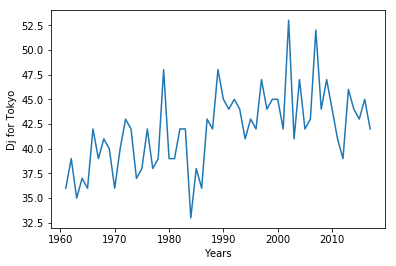

In [47]:
totalData = totalDataset.shape[0]

Tf = []
countOn = False
sumTemp = 0
for i in range(totalData):
    if totalDataset[i, 2] == 1 and totalDataset[i, 3] == 1:
        countOn = True
    if countOn :
        sumTemp += totalDataset[i, 9]      # this data is taken as the average temperature of the day
    if totalDataset[i, 2] == 3 and totalDataset[i, 3] == 31:
        countOn = False
        if calendar.isleap(totalDataset[i, 1]):
            Tf.extend([sumTemp / 91])
        else:
            Tf.extend([sumTemp / 90])
        sumTemp = 0
phi = 35 + 40 / 60
L = 40
Ts = 17 + 273
Tf = np.array(Tf)

Dj = np.round(136.75 - 7.689 * phi + 0.133 * phi ** 2 - 1.307 * np.log(L) + 0.144 * Tf + 0.285 * np.power(Tf, 2))
print("Dj", Dj)

plt.figure(1)
plt.plot([i for i in range(1961, 2018)], Dj)
plt.xlabel('Years')
plt.ylabel('Dj for Tokyo')
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


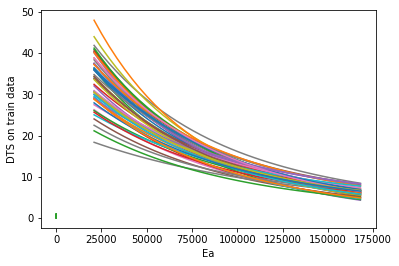

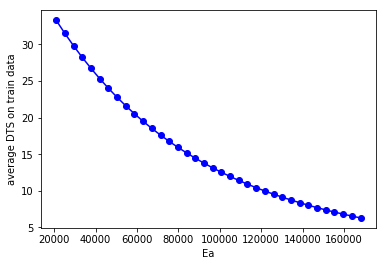

In [48]:
Ea = np.array([i for i in range(5, 41)]) * 4.2 * 1000
R = 8.314
DTSbias = 0
years = [ i for i in range(1961, 2018)]
yearDays = []
daysSum = 0
for i in years:
    yearDays.extend([daysSum])
    if calendar.isleap(i):
        daysSum += 366
    else:
        daysSum += 365
yearDays = np.array(yearDays)
DjIndex = yearDays + Dj

DTS = []
for eaIndex in range(len(Ea)):
    tempDTS = []
    for i in range(len(years)):
        Tij = (totalDataset[int(DjIndex[i]): bloomDateIndex[i] + 1, 9] + 273)
        dtsSum = np.sum(np.exp(Ea[eaIndex] * (Tij - Ts) / (R * Tij * Ts))) + DTSbias
        tempDTS.extend([dtsSum])
    DTS.extend([tempDTS])
DTS = np.array(DTS)

testYears = [1966, 1971, 1985, 1994, 2008]
trainYears = [i - 1961 for i in range(1961, 2018) if i not in testYears]
testYears = [i for i in range(2018 - 1961) if i not in trainYears]

trainDTS = DTS[:, trainYears]
meanTrainDTS = np.mean(trainDTS, axis=1)

plt.plot(Ea, trainDTS, np.random.rand(36,1))
plt.xlabel('Ea')
plt.ylabel('DTS on train data')
plt.show()

plt.figure(2)
plt.plot(Ea, meanTrainDTS, 'b', Ea, meanTrainDTS, 'bo')
plt.xlabel('Ea')
plt.ylabel('average DTS on train data')
plt.show()

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

Ea (in kCal):  27.0
Mean DTS = 10.910325933657292


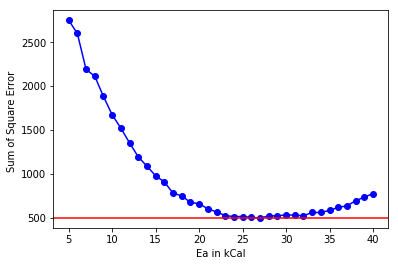

In [49]:
predictionTrainError, p = predictingBloomDate(bloomDateIndex, DjIndex, meanTrainDTS, totalDataset, trainYears, Ea, Ts)
error = predictionTrainError / len(predictionTrainError)

EaInkCal = Ea / (4.2 * 1000)
optimalIndex = np.argmin(predictionTrainError)
optimalEa = Ea[optimalIndex]
optimalMeanDTS = meanTrainDTS[optimalIndex]

print('Ea (in kCal): ', EaInkCal[optimalIndex])
print('Mean DTS =', optimalMeanDTS)

plt.plot(EaInkCal, predictionTrainError, 'b', EaInkCal, predictionTrainError, 'bo')
plt.axhline(y=predictionTrainError[optimalIndex], color='r', linestyle='-')
plt.xlabel('Ea in kCal')
plt.ylabel('Sum of Square Error ')
plt.show()

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [51]:
predictionTestError, predictionTestBloomDate = predictingBloomDate(bloomDateIndex, DjIndex, np.mat(optimalMeanDTS),
                                                                   totalDataset,testYears, optimalEa, Ts)


march1ToBloomDateDays = np.array(bloomDateIndex) - np.array(march1Index)
actualBloomDateAverage = np.round(np.mean(march1ToBloomDateDays)) + march1Index

SSres = predictionTestError
SStot = np.sum(np.power(np.array(bloomDateIndex)[testYears] - actualBloomDateAverage[testYears], 2))
rSquareTest = 1 - SSres / SStot
print('R\u00b2 for test years for optimal Ea =', rSquareTest[0])
print('Error on prediction (days)', np.abs(np.array(bloomDateIndex)[testYears] - np.ravel(predictionTestBloomDate)))

R² for test years for optimal Ea = 0.9459459459459459
Error on prediction (days) [1 1 2 1 1]


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1. According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2. There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.


3. Variation of max temp is not given. So if we can have variation from post hibernation state to blooming date we can see a better scanerio.


4. Besides, blooming of sakura is a chemical reaction. So the environmental factor becomes very important like humidity, rain, snow which effects the environment. Thus it can effect sakura blooming date.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

## Creating Train Data for NN

In [52]:
traindataset = pd.read_csv('traindataset.csv', header=0)

traindataset = traindataset[traindataset["month"] != 1]

#getting all the years bloom data and making sum of that data
traindataset = traindataset[traindataset.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]

#getting the sum of all train features data for each year till blooming date
local_pressure = traindataset.groupby("year", group_keys=False)["local pressure"].sum()
sea_pressure = traindataset.groupby("year", group_keys=False)["sea pressure"].sum()
total_preci = traindataset.groupby("year", group_keys=False)["total preci"].sum()
hr1_preci = traindataset.groupby("year", group_keys=False)["hr1 preci"].sum()
min10_preci = traindataset.groupby("year", group_keys=False)["min10 preci"].sum()
avg_temp = traindataset.groupby("year", group_keys=False)["avg temp"].sum()
max_temp = traindataset.groupby("year", group_keys=False)["max temp"].sum()
min_temp = traindataset.groupby("year", group_keys=False)["min temp"].sum()
avg_humid = traindataset.groupby("year", group_keys=False)["avg humid"].sum()
min_humid = traindataset.groupby("year", group_keys=False)["min humid"].sum()
sun_hours = traindataset.groupby("year", group_keys=False)["sun hours"].sum()

#removing year column from pandas series as we already have year in train dataframe
local_pressure = local_pressure.reset_index(level='year', drop=True)
sea_pressure = sea_pressure.reset_index(level='year', drop=True)
total_preci = total_preci.reset_index(level='year', drop=True)
hr1_preci = hr1_preci.reset_index(level='year', drop=True)
min10_preci = min10_preci.reset_index(level='year', drop=True)
avg_temp = avg_temp.reset_index(level='year', drop=True)
max_temp = max_temp.reset_index(level='year', drop=True)
min_temp = min_temp.reset_index(level='year', drop=True)
avg_humid = avg_humid.reset_index(level='year', drop=True)
min_humid = min_humid.reset_index(level='year', drop=True)
sun_hours = sun_hours.reset_index(level='year', drop=True)

#creating train dataframe and adding data
train_new_data = pd.DataFrame(columns = traindataset.columns)
train_new_data['local pressure'] = local_pressure
train_new_data['sea pressure'] = sea_pressure
train_new_data['total preci'] = total_preci
train_new_data['hr1 preci'] = hr1_preci
train_new_data['min10 preci'] = min10_preci
train_new_data['avg temp'] = avg_temp
train_new_data['max temp'] = max_temp
train_new_data['min temp'] = min_temp
train_new_data['avg humid'] = avg_humid
train_new_data['min humid'] = min_humid
train_new_data['sun hours'] = sun_hours


In [53]:
traindataset = pd.read_csv('sakura.csv', header=0)
trainyear = yearlist
daylist = []
days = 0

#creating train dataframe till blooming date
for yearcount in range(0, len(trainyear)):
    for i in traindataset[traindataset.year == trainyear[yearcount]].serial:
        rowData = traindataset.iloc[i]
        #train_new_data = train_new_data.append(rowData, ignore_index=True)
        days += 1
        if(rowData['bloom'] == 1):
            daylist.append(days)
            break
    days = 0

In [54]:
train_new_data['days'] = daylist
train_new_data = train_new_data.drop(['year', 'month', 'day', 'serial', 'bloom'], axis=1)
train_new_data

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,days
0,60865.8,60908.4,150.1,31.1,7.8,395.7,721.0,118.4,3311,2097,388.6,91
1,60787.2,60830.1,79.0,19.8,7.4,432.1,768.1,129.6,3205,1927,395.6,91
2,60845.6,60888.6,108.0,29.3,8.5,387.6,701.7,113.5,3257,1994,409.2,91
3,63055.0,63099.6,163.7,46.2,11.1,388.6,676.6,139.1,3505,2300,368.8,93
4,61546.6,61814.9,66.5,26.5,13.0,361.5,642.2,94.9,3018,1968,465.8,92
5,58758.7,59015.2,112.5,32.2,8.3,417.4,660.8,169.8,3203,2255,336.6,89
6,58652.2,58908.1,115.5,42.0,16.5,406.4,654.6,151.7,2895,1897,357.6,89
7,65768.1,66054.7,228.0,60.0,20.0,469.6,724.0,214.1,3815,2570,304.1,96
8,66761.5,67053.5,92.5,25.5,9.5,410.7,696.3,132.5,3465,2242,378.7,97
9,57559.0,57809.8,172.0,60.5,24.0,399.1,610.4,201.5,3168,2263,298.6,88


Here I am creating a train dataset with sum of all features for each year because it is necessary to know total value of each feature till blooming date. Thus we can have overall picture how was the weather till blooming date.

In [55]:
train_matrix = np.matrix(train_new_data)
features = train_new_data.columns.tolist() #listing all the features
train_features_matrix = np.matrix(train_new_data.drop(['days'],axis = 1)) 
#removing the y train data from main dataframe

In [56]:
#creating train target data
train_label = np.array(train_new_data.days).reshape((train_new_data.shape[0],1))
daydata = train_label.tolist()
daylist = []
for i in range(0, len(daydata)):
    daylist.append(daydata[i][0])

## Scaling data and standardization

Here i am standardization the dataset. It is important to standardize the dataset. By using this process, the mean of all the input features equal to 0 and also converts their variance to 1. Using this system, it ensures that there is no bias while training the model due to the different scales/values of all input features. Without this, neural network might get confused and give a higher weight to those features which have a higher average value than others.

To standardize data, I have used MinMaxScaler Method as it is sensitive to outliers and feature value falls within a bounded interval.

First I am converting dataframe to numpy matrix for easier calculation process and then scaling that matrix and saving that into dataset

### Preprocessing Train Data

In [57]:
preprocessing_label = MinMaxScaler()
preprocessing_label.fit(np.mat(daylist))
preprocessing_train_matrix = MinMaxScaler()
preprocessing_train_matrix.fit(train_matrix)
preprocessing_train_features_matrix = MinMaxScaler()
preprocessing_train_features_matrix.fit(train_features_matrix)

#saving all the transformed value in dataset
train_new_data = pd.DataFrame(preprocessing_train_matrix.transform(train_matrix),columns = features)
y_train = train_new_data.days
x_train = train_new_data.drop(['days'], axis=1)

## Creating Test Data for NN

In [58]:
testdataset = pd.read_csv('testdataset.csv', header=0)

testdataset = testdataset[testdataset["month"] != 1]

#getting all the years bloom data and making sum of that data
testdataset = testdataset[testdataset.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]

#getting the sum of all test features data for each year till blooming date
local_pressure = testdataset.groupby("year", group_keys=False)["local pressure"].sum()
sea_pressure = testdataset.groupby("year", group_keys=False)["sea pressure"].sum()
total_preci = testdataset.groupby("year", group_keys=False)["total preci"].sum()
hr1_preci = testdataset.groupby("year", group_keys=False)["hr1 preci"].sum()
min10_preci = testdataset.groupby("year", group_keys=False)["min10 preci"].sum()
avg_temp = testdataset.groupby("year", group_keys=False)["avg temp"].sum()
max_temp = testdataset.groupby("year", group_keys=False)["max temp"].sum()
min_temp = testdataset.groupby("year", group_keys=False)["min temp"].sum()
avg_humid = testdataset.groupby("year", group_keys=False)["avg humid"].sum()
min_humid = testdataset.groupby("year", group_keys=False)["min humid"].sum()
sun_hours = testdataset.groupby("year", group_keys=False)["sun hours"].sum()

#removing year column from pandas series as we already have year in test dataframe
local_pressure = local_pressure.reset_index(level='year', drop=True)
sea_pressure = sea_pressure.reset_index(level='year', drop=True)
total_preci = total_preci.reset_index(level='year', drop=True)
hr1_preci = hr1_preci.reset_index(level='year', drop=True)
min10_preci = min10_preci.reset_index(level='year', drop=True)
avg_temp = avg_temp.reset_index(level='year', drop=True)
max_temp = max_temp.reset_index(level='year', drop=True)
min_temp = min_temp.reset_index(level='year', drop=True)
avg_humid = avg_humid.reset_index(level='year', drop=True)
min_humid = min_humid.reset_index(level='year', drop=True)
sun_hours = sun_hours.reset_index(level='year', drop=True)

#creating test dataframe and adding data
test_new_data = pd.DataFrame(columns = testdataset.columns)
test_new_data['local pressure'] = local_pressure
test_new_data['sea pressure'] = sea_pressure
test_new_data['total preci'] = total_preci
test_new_data['hr1 preci'] = hr1_preci
test_new_data['min10 preci'] = min10_preci
test_new_data['avg temp'] = avg_temp
test_new_data['max temp'] = max_temp
test_new_data['min temp'] = min_temp
test_new_data['avg humid'] = avg_humid
test_new_data['min humid'] = min_humid
test_new_data['sun hours'] = sun_hours

In [59]:
# finding total days till bloom
testdataset = pd.read_csv('sakura.csv', header=0)
testdaylist = []
testdays = 0
for yearcount in range(0, len(testyear)):
    for i in testdataset[testdataset.year == testyear[yearcount]].serial:
        rowData = testdataset.iloc[i]
        testdays += 1
        if(rowData['bloom'] == 1):
            testdaylist.append(testdays)
            break
    testdays = 0

In [60]:
test_new_data['days'] = testdaylist
test_new_data = test_new_data.drop(['year', 'month', 'day', 'serial', 'bloom'], axis=1)
test_new_data

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,days
0,48442.9,48652.5,181.4,61.6,20.0,400.3,607.6,187.0,2650,1847,244.4,79
1,58663.9,58920.0,87.0,32.5,9.0,411.7,663.4,171.9,3068,1937,352.2,89
2,62811.8,63085.2,276.5,58.0,20.5,457.5,677.8,257.7,3994,2824,253.3,93
3,59553.5,59812.8,203.0,53.0,14.0,434.0,656.6,234.3,2950,1922,364.3,90
4,51594.0,51822.6,141.5,49.5,17.5,388.9,596.7,205.2,2296,1426,352.7,82


In [61]:
test_matrix = np.matrix(test_new_data)
features = test_new_data.columns.tolist()
test_features_matrix = np.matrix(test_new_data.drop(['days'], axis=1))

In [62]:
test_label = np.array(test_new_data.days).reshape((test_new_data.shape[0],1))
testdaydata = test_label.tolist()
testdaylist = []
for i in range(0, len(testdaydata)):
    testdaylist.append(daydata[i][0])

In [63]:
preprocessing_train_matrix = MinMaxScaler()
preprocessing_train_matrix.fit(test_matrix)
preprocessing_train_features_matrix = MinMaxScaler()
preprocessing_train_features_matrix.fit(test_features_matrix)

#saving all the transformed value in dataset
test_new_data = pd.DataFrame(preprocessing_train_matrix.transform(test_matrix),columns = features)

In [64]:
y_test = test_new_data.days
x_test = test_new_data.drop(['days'], axis=1)

## Neural Network Model Using TensorFlow

In [65]:
number_features = x_train.shape[1]

# Number of Neurons
number_neurons_1 = 512
number_neurons_2 = 256
number_neurons_3 = 128

neuralnetwork = tf.InteractiveSession()
X = tf.placeholder(dtype=tf.float32, shape=(None, number_features))
Y = tf.placeholder(dtype=tf.float32, shape=(None))
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()
# Hidden weights:

#Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([number_features, number_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([number_neurons_1]))

#Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([number_neurons_1, number_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([number_neurons_2]))

#Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([number_neurons_2, number_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([number_neurons_3]))

# Output weights:
#Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([number_neurons_3, 1]))
bias_out = tf.Variable(bias_initializer([1]))
#end of defining the network


#start of architecture of neural network
#hidden layers of the network are transformed by activation functions. So for that, ReLU(Rectified Linear Unit) is used.
#Because ReLU is sparsity and reduced likelihood of vanishing gradient.
#On the other hand, Sigmoid or others might generate some non-zero value resulting in dense representations
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))

out = tf.transpose(tf.add(tf.matmul(hidden_3, W_out), bias_out))
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
lr=0.1
opt = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(mse)
# Run initializer
neuralnetwork.run(tf.global_variables_initializer())

#Fitting the neural network
batch_size = 100
epochs = 10

#running till epochs
for e in range(epochs):
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size #getting the start point of dataset
        batch_x = x_train[start:start + batch_size] #getting the feature column values from start to batch size
        batch_y = y_train[start:start + batch_size] #getting the target column values from start to batch size
        neuralnetwork.run(opt, feed_dict={X: batch_x, Y: batch_y}) #feeding the network

In [66]:
pred = neuralnetwork.run(out, feed_dict={X: x_test})

In [67]:
r2_nn = abs(r2_score(y_test.values, pred[0]))

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

R² score using Tmean:  0.8323615160349854
R² score using 600C:  0.6793002915451896
R² for test years for optimal Ea:  0.9459459459459459
R² score using neural network:  1.0543945303695366


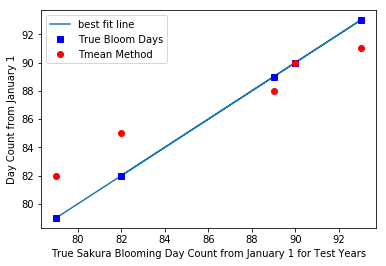

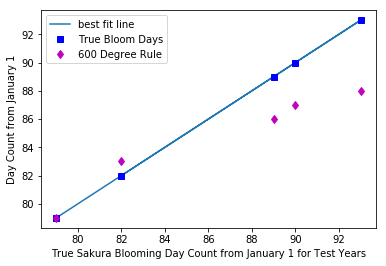

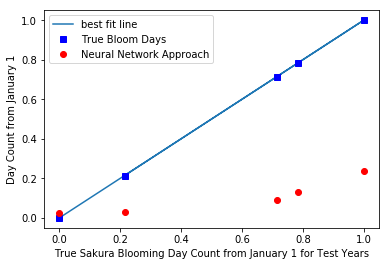

In [68]:
print('R\u00b2 score using Tmean: ', r2_tmean)
print('R\u00b2 score using 600C: ', r2_sixhundred)
print('R\u00b2 for test years for optimal Ea: ', rSquareTest[0])
print('R\u00b2 score using neural network: ', r2_nn)

plt.plot(days_bloom_actual, days_bloom_actual, label= 'best fit line')
plt.plot(days_bloom_actual, days_bloom_actual, 'bs', label = 'True Bloom Days')
plt.plot(days_bloom_actual, days_bloom_tmean, 'ro', label = 'Tmean Method')
plt.xlabel('True Sakura Blooming Day Count from January 1 for Test Years')
plt.ylabel('Day Count from January 1')
plt.legend()
plt.show()

plt.plot(days_bloom_actual, days_bloom_actual, label = 'best fit line')
plt.plot(days_bloom_actual, days_bloom_actual, 'bs', label = 'True Bloom Days')
plt.plot(days_bloom_actual, days_bloom_sixhundred, 'md', label = '600 Degree Rule')
plt.xlabel('True Sakura Blooming Day Count from January 1 for Test Years')
plt.ylabel('Day Count from January 1')
plt.legend()
plt.show()

plt.plot(y_test.values, y_test.values, label = 'best fit line')
plt.plot(y_test.values, y_test.values, 'bs', label = 'True Bloom Days')
plt.plot(y_test.values, pred[0], 'ro', label = 'Neural Network Approach')
plt.xlabel('True Sakura Blooming Day Count from January 1 for Test Years')
plt.ylabel('Day Count from January 1')
plt.legend()
plt.show()

Here Neural Network approach giving less accurate data because of small dataset used for test case.

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

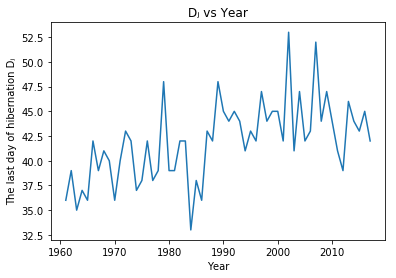

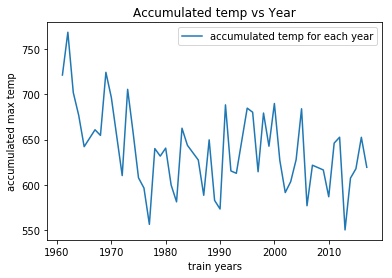

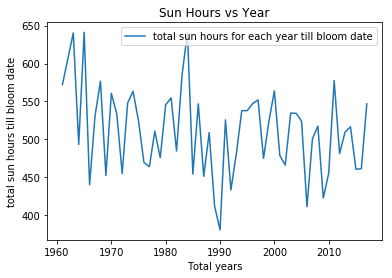

In [69]:
year = [ i for i in range(1961, 2018)]
plt.plot(year,Dj)
plt.ylabel("The last day of hibernation D\u2C7C")
plt.xlabel("Year")
plt.title('D\u2C7C vs Year')
plt.show()

tmean = pd.read_csv('Tmean.csv', names = ["year", "traintemp"])
train_years=tmean.year
accumulated_temp=tmean.traintemp

plt.plot(train_years, accumulated_temp, label = 'accumulated temp for each year')
plt.title('Accumulated temp vs Year')
plt.xlabel('train years')
plt.ylabel('accumulated max temp')
plt.legend()
plt.show()

dataset = pd.read_csv("sakura.csv", header=0)
dataset = dataset[dataset.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]
sun_hours = dataset.groupby("year", group_keys=False)["sun hours"].sum()
sun_hours = sun_hours.reset_index(level='year', drop=True)
year=[i for i in range(1961,2018)]
plt.plot(year, sun_hours, label = 'total sun hours for each year till bloom date')
plt.title('Sun Hours vs Year')
plt.xlabel('Total years')
plt.ylabel('total sun hours till bloom date')
plt.legend()
plt.show()

Based on the previous data, we can say that if D<sub>j</sub> changes, it effects the blooming date. As we can see that if D<sub>j</sub> increases, blooming date increase. Besides, accumulated max temp also plays an important part. As we can see, in 1970 the accumulated max temp is increased and blooming is becoming more earlier. Besides, Sun hours is also increasing each year. So it is also helping to make hibernation more earlier.